## Building a simple CIFAR-10 image classifier using deep learning

In [1]:
import datetime

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

%matplotlib inline
import matplotlib.pyplot as plt

print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.0.0


### Defining a model

In [2]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

### Setting up a data pipeline
To train this model, we need a data pipeline to feed it labeled training data. A data pipeline performs the following tasks:<br>
<li><b>Loading</b>: Copying the dataset (e.g. images and labels) from storage into the program's memory.<br>
<li><b>Preprocessing</b>: transforming the dataset. For example, in image classification, we might resize, whiten, shuffle, or batch images.<br>
<li><b>Feeding</b>: shoveling examples from a dataset into a training loop.<br>

### Loading data from Cloud


In [3]:
(train_data, train_label), (test_data, test_label) = keras.datasets.cifar10.load_data()
print("train_data shape: ", np.shape(train_data))
print("train_label shape: ", np.shape(train_label))

print("\n")

print("test_data shape: ", np.shape(test_data))
print("test_label shape: ", np.shape(test_label))

# Get info for test data
N_EXAMPLE,HEIGHT,WIDTH,NUM_CHANNELS = np.shape(test_data)

train_data shape:  (50000, 32, 32, 3)
train_label shape:  (50000, 1)


test_data shape:  (10000, 32, 32, 3)
test_label shape:  (10000, 1)


`train_data` represents 50,000 images with dimension 32 x 32 x 3 (width, height, and three RGB channels).<br>
`train_label` represents labels for these 50,000 images.

In [4]:
#n = 5 # number of images to display
#i = 1
#fig = plt.figure()
#
#for image, label in train_dataset.take(n):
#    ax = fig.add_subplot(1,n,i)
#    ax.grid('off')
#    ax.axis('off')
#    plt.imshow(image)
#    i = i + 1
#plt.show()
# Display Data
def display_image(data,rows=3,cols=3):
    n=1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))

    for i in range(cols):
        for j in range(rows):
            for image , label in data.take(n):
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                plt.imshow(image)
        
                pred_label = 0.0 #cifar10_classes[y_pred_test_classes[random_index]]
                pred_proba = 0.0 #y_pred_test_max_probas[random_index]
                true_label = cifar10_classes[label.numpy()[0]]
                ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
                pred_label, pred_proba, true_label))
            n = n + 1
plt.show()

<b>In theory, we could simply feed these raw data into a training loop and call this a data pipeline. However, to achieve higher model accuracy, we'll want to preprocess the data (i.e. perform certain transformations on it before usage). To do so, we leverage <i>Tensorflow's Dataset class.</i></b>

### The tf.data.Dataset class

The TensorFlow Dataset class serves two main purposes:<br>
<li>It acts as a container that holds training data.
<li>It can be used to perform alterations on elements of the training data.
    
We instantiate a `tensorflow.data.Dataset` object representing the CIFAR-10 dataset as follows:

In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

# Instantiate the Dataset class.
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_data, test_label))

C:\Users\lauro\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


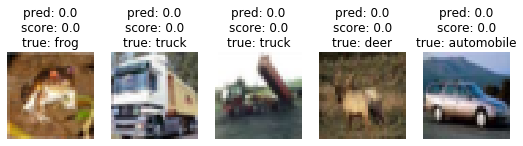

In [6]:
display_image(train_dataset,rows=1,cols=5)

During training, the CIFAR-10 training examples stored in `train_dataset` will be accessed via the `take()` iterator:

### Data augmentation
Augmentation is often used to <b>"inflate"</b> training datasets, which can improve generalization performance.<br>

Let's augment the CIFAR-10 dataset by performing the following steps on every image:<br>
1. Pad the image with a black, four-pixel border.
2. Randomly crop a 32 x 32 region from the padded image.
3. Flip a coin to determine if the image should be horizontally flipped.<br><br>

We achieve this by first defining a function that, given an image, performs the Steps 1-3 above:

In [7]:
def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y

Next, we call the method `map`; this call returns a new `Dataset` object that contains the result of passing each image in CIFAR-10 into `augmentation`. This new object will emit transformed images in the original order:

C:\Users\lauro\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


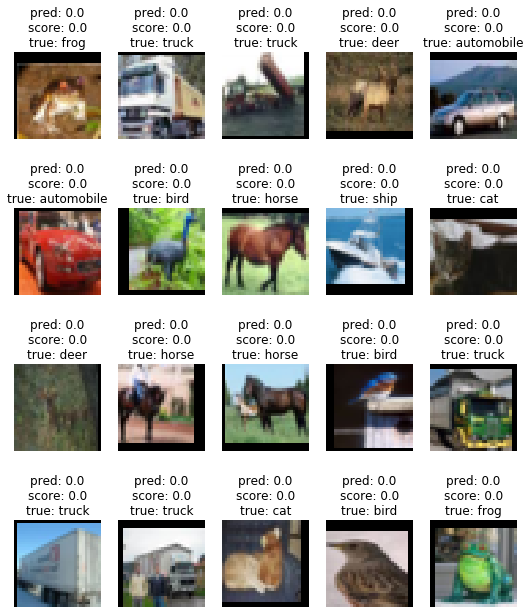

In [8]:
train_datasets = train_dataset.map(augmentation)
display_image(train_datasets,rows=4,cols=5)

### Shuffling
We randomly shuffle the dataset. TensorFlow Dataset has a `shuffle` method, which can be chained to our augmentation as follows:

In [9]:
train_datasets = (train_dataset
                 .map(augmentation)
                 .shuffle(buffer_size=N_EXAMPLE))

C:\Users\lauro\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


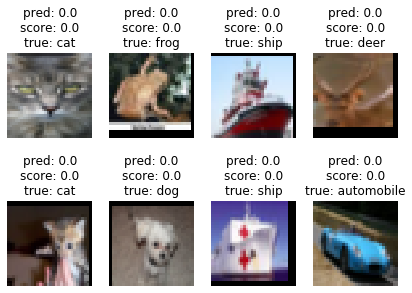

In [10]:
display_image(train_datasets,rows=2,cols=4)

For perfect shuffling, the `buffer_size` should be greater than or equal to the size of the dataset (in this case: 50,000); for large datasets, this isn't possible.

### Normalization
It's common practice to normalize data. Here, define a function that linearly scales each image to have zero mean and unit variance:

In [11]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

Next, we chain it with our augmentation and shuffling operations:

In [12]:
train_datasets = (train_dataset
                 .map(augmentation)
                 .shuffle(buffer_size=N_EXAMPLE)
                 .map(normalize))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Batching
Finally, we `batch` the dataset. We set `drop_remainder` to `True` to remove enough training examples so that the training set's size is divisible by `batch_size`.

In [13]:
train_dataset = (train_dataset.map(augmentation)
                 .map(normalize)
                 .shuffle(N_EXAMPLE)
                 .batch(128, drop_remainder=True))
print(train_dataset)

<BatchDataset shapes: ((128, 32, 32, 3), (128, 1)), types: (tf.uint8, tf.uint8)>


We now have a complete data pipeline. Now we can start training.

### Training the model
A Keras model needs to be compiled before training. Compilation essentially defines three things: the `loss function`, the `optimizer` and the `metrics` for evaluation:

In [14]:
model.compile(
          loss='sparse_categorical_crossentropy',
          optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
          metrics=['accuracy'])

Notice we use `sparse_categorical_crossentropy` and `sparse_categorical_accuracy` here because each label is represented by a single integer (index of the class). One should use `categorical_crossentropy` and `categorical_accuracy` if a one-hot vector represents each label.

In [15]:
model.fit(train_dataset,
          epochs=15,
          validation_data=test_dataset,
          validation_freq=1)

Epoch 1/15
390/390 [==============================] - 36s 93ms/step - loss: 5080.9483 - accuracy: 0.0991


ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (32, 32, 3)